Importation & Dataframe Creation
====

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')


file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600.csv')


"""Normalisation"""

df_primary['bdb_high_n'] = df_primary['bdb_high'] / df_primary['opening_price']
df_primary['bdb_low_n'] = df_primary['bdb_low'] / df_primary['opening_price']
df_primary['high_price_n'] = df_primary['high_price'] / df_primary['opening_price']
df_primary['low_price_n'] = df_primary['low_price'] / df_primary['opening_price']
df_primary['mme12_n'] = df_primary['mme12'] / df_primary['opening_price']
df_primary['mme26_n'] = df_primary['mme26'] / df_primary['opening_price']
df_primary['macd_n'] = df_primary['macd'] / df_primary['opening_price']

"""Variables supplémentaires"""

df_primary['variation'] = (df_primary['closing_price'] - df_primary['opening_price']) / df_primary['opening_price']*100
df_primary['macd_derivative_n'] = df_primary['macd_n'] - df_primary['macd_n'].shift(1)
df_primary['macd_historic'] = df_primary['macd_n'] + df_primary['macd_n'].shift(2)
df_primary['derivate_stochastic'] = df_primary['stochastic'] - df_primary['stochastic'].shift(1)
df_primary['volatility'] = df_primary['high_price_n'] - df_primary['low_price_n']
df_primary['derivate_volatility'] = df_primary['volatility'] - df_primary['volatility'].shift(1)
df_primary['derivate_volume'] = df_primary['volume'] - df_primary['volume'].shift(1)
df_primary['bdb_gap'] = df_primary['bdb_high_n'] - df_primary['bdb_low_n']

"""abandon des variables redondantes"""

df_primary = df_primary.drop('closing_price', axis = 1)
df_primary = df_primary.drop('bdb_low', axis = 1)
df_primary = df_primary.drop('bdb_high', axis = 1)
df_primary = df_primary.drop('mme12', axis = 1)
df_primary = df_primary.drop('mme26', axis = 1)
df_primary = df_primary.drop('opening_price', axis = 1)
df_primary = df_primary.drop('low_price', axis = 1)
df_primary = df_primary.drop('high_price', axis = 1)
df_primary = df_primary.drop('length', axis = 1)
df_primary = df_primary.drop('date', axis = 1)
df_primary = df_primary.drop('macd', axis = 1) 

"""On décale d'un cran notre variation afin de pouvoir faire une étude cohérente"""

df_primary['variation'] = df_primary['variation'].shift(-1)

"""On lâche nos NaN"""

df_primary.dropna(inplace=True)
df = df_primary.copy()

df_primary[['macd_n','macd_derivative_n','macd_historic']].describe()
df.head()


,timestamp,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,mme12_n,mme26_n,macd_n,variation,macd_derivative_n,macd_historic,derivate_stochastic,volatility,derivate_volatility,derivate_volume,bdb_gap
2,1504321200,31.744749,0.000000,0.998576,0.980936,1.002080,0.981055,0.861726,0.855708,0.006018,0.350023,-0.001876,0.014325,-0.201000,0.021024,0.011466,16.653545,0.017640
3,1504324800,14.755165,0.642795,1.016936,0.999783,1.006496,0.998110,0.876122,0.871322,0.004800,-4.397400,-0.001218,0.012694,0.642795,0.008385,-0.012639,-16.989584,0.017152
4,1504328400,185.642850,0.261647,1.016472,0.989490,1.000002,0.940442,0.865095,0.864926,0.000169,3.518990,-0.004631,0.006187,-0.381148,0.059560,0.051175,170.887684,0.026982
5,1504332000,141.111493,0.999927,1.063922,1.035350,1.035192,1.000000,0.903820,0.904702,-0.000882,-0.592246,-0.001051,0.003918,0.738280,0.035192,-0.024368,-44.531356,0.028572
6,1504335600,100.007762,0.160596,1.027695,0.998875,1.013428,0.990375,0.870613,0.872997,-0.002384,-0.144347,-0.001502,-0.002215,-0.839332,0.023053,-0.012140,-41.103732,0.028820


Gain function
====
Parameters
----
*def strategy_based_results*(decisions_list, market_prices_deltas, fee_rate=0.3, gradient = False)<br>
return decisions results <br>

*normally decisions_results* = [list with the evolution of your gain]<br>
if *gradient* = True *decisions_results* = the final gain<br>
if *efficiency* = True returns a list with gain during the buying chandeliers & a list with avoided gain when selling<br>
*decisions_list* = [list with -1 for sell 0 for hold and 1 for buy]<br>
*market_prices_delta* = [list with variation for each chandelier]<br>
*fee_rate* = fee you want to apply<br>
*gradient* = Boolean, if True will give you <br>

Example
----
decisions_results = strategy_based_results(decisions_list, market_prices_deltas)

In [2]:
def strategy_based_results(decisions_list, market_prices_deltas, fee_rate=0.3, gradient = False, efficiency = False):
    """
    Returns the list of successive gains.
    Prints other info like number of hold, buy, sell, free_cash, fee costs.
    """

    cash = True
    decisions_results = [100]
    decisions_results_evite = [100]
    fees_cost = [100]
    free_cash = 0
    achat = 0
    vente = 0
    hold = 0
    if not gradient and not efficiency:
        
        for i in range(len(decisions_list)):

            if decisions_list[i] == 1 and cash:
                # Buy
                cash = False
                decisions_results.append(
                    decisions_results[-1]*(100 + market_prices_deltas[i] - fee_rate) / 100)
                fees_cost.append(
                    fees_cost[-1] + decisions_results[-1] * fee_rate / 100)
                achat += 1

            elif decisions_list[i] == -1 and cash:
                # Wait
                decisions_results.append(decisions_results[-1])
                free_cash += 1

            elif decisions_list[i] == 0 and cash:
                # Wait
                decisions_results.append(decisions_results[-1])
                free_cash += 1

            elif decisions_list[i] == 0 and not cash:
                # Hold
                decisions_results.append(
                    decisions_results[-1] * (100 + market_prices_deltas[i]) / 100)
                hold += 1

            elif decisions_list[i] == -1 and not cash:
                # Sell
                cash = True
                decisions_results.append(
                    decisions_results[-1] * (100 - fee_rate) / 100)
                fees_cost.append(
                    fees_cost[-1] + decisions_results[-1] * fee_rate / 100)
                vente += 1

            elif decisions_list[i] == 1 and not cash:
                # Hold
                decisions_results.append(
                    decisions_results[-1] * (100 + market_prices_deltas[i]) / 100)
                hold += 1

            else:
                raise Exception
        transactions = achat + vente
        print("Gain total = ", str(round(decisions_results[-1] - 100,2)), "%.")
        print("Nombre de transactions = ", str(achat + vente))
        print("Argent dépensé en commissions = ", str(round(fees_cost[-1] - 100, 2)), "%.")
        print("Nombre de chandeliers sans cash engagé = ", str(free_cash))
        print("Nombre de chandeliers sur lesquels on a juste hold = ", str(hold))
        return decisions_results

    elif gradient:
        decisions_results = 100

        for i in range(len(decisions_list)):
            if cash:
                if decisions_list[i] == 1:
                    # Buy
                    cash = False
                    decisions_results = decisions_results * (100 + market_prices_deltas[i] - fee_rate) / 100

            else:
                if decisions_list[i] in [0,1]:
                    # Hold
                    decisions_results = decisions_results * (100 + market_prices_deltas[i]) / 100

                else:
                    # Sell
                    cash = True
                    decisions_results = decisions_results * (100 - fee_rate) / 100
        
        return decisions_results

    elif efficiency:
        for i in range(len(decisions_list)):
            if decisions_list[i] == 1:           
                decisions_results.append(decisions_results[-1]*(100 + market_prices_deltas[i] - fee_rate) / 100)
            elif decisions_list[i] == -1:
                decisions_results_evite.append(decisions_results_evite[-1]*(100+market_prices_deltas[i]+fee_rate)/100)


        return decisions_results, decisions_results_evite
        

Real Evolution function
====
Return a list with the real evolution of market prices

In [3]:
def buy_hold_results(market_prices_deltas):
    """
    Return the lists of real market prices evolution
    """
    market_var = [100]
    for delta in market_prices_deltas:
        market_var.append(market_var[-1] * (100 + delta) / 100)
    return market_var

MACD creation decision vector
====
Parameters
----
 def macd(data_row, seuil_a = -0.05, seuil_b = 0.0019, seuil_c = 0.014, seuil_d = -0.0225)
    return(-1 / 0 / 1 depending on data_row value)

seuil_a = macd
seuil_b = derivate_macd
seuil_c = second_derivate_macd for buying
seuil_d = second_derivate_macd for selling

default parameters are optimized for the whole dataset (Gain = 589%)

In [4]:
 def macd(data_row, seuil_a = -0.05, seuil_b = 0.0019, seuil_c = 0.014, seuil_d = -0.0225):
        
    macd = data_row['macd_n']
    macd_derivative = data_row['macd_derivative_n']
    macd_historic = data_row['macd_historic']
    
    if macd >= seuil_a:
        if macd_derivative > seuil_b and macd_historic > seuil_c:
            return 1
        else:
            if macd_historic <= seuil_d:
                return -1
            else:
                return 0
    else:
        return -1
    
    

Threshold Optimisation
====
Parameters
---
def optimisation_seuil(seuil, pas, debut, fin, seuil_a = -0.05, seuil_b = 0.0019, seuil_c = 0.014, seuil_d = -0.0225)
return seuil
seuil = 'entre guillemets la lettre associée au seuil à optimiser'
pas = définition du pas
debut = où commencer l'optimisation
fin = où la finir
seuil_a/b/c/d par défaut ceux optimisés.

Example
----
seuil_a = optimisation_seuil(seuil = 'a', pas = 0.1, debut = -0.5, fin= 0)

In [5]:
def optimisation_seuil(seuil, pas, debut, fin, seuil_a = -0.05, seuil_b = 0.0019, seuil_c = 0.014, seuil_d = -0.0225):
    init = debut
    liste_gain = []
    
    while debut < fin:  
        if seuil == 'a':
            df_primary['macd_decision'] =  df_primary.apply(macd, args = (debut, seuil_b, seuil_c, seuil_d), axis=1)
        elif seuil == 'b':
            df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, debut, seuil_c, seuil_d), axis=1)
        elif seuil == 'c':
            df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, seuil_b, debut, seuil_d), axis=1)
        elif seuil == 'd':
            df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, seuil_b, seuil_c, debut), axis=1)
        else:
            return("vous avez mal entré le seuil à optimiser")
        decisions_list = df_primary['macd_decision'].values.tolist()
        market_prices = df_primary['variation'].values.tolist()
        decisions_results = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3, gradient = True)
        market_var = buy_hold_results(market_prices)
        liste_gain.append(decisions_results)
        debut += pas
        left = (fin - debut) / pas
        print(str(round(left,0)))
        
    index = liste_gain.index(max(liste_gain))
    seuil_a = index = index * pas + init
    print("Index du max = ", str(round(seuil_a ,4)))
    print("Gain max =", str(round(max(liste_gain),2)))
    L = [i for i in range(len(liste_gain))]
    plt.plot(L, liste_gain)
    plt.show()
    return(seuil)

4.0
3.0
2.0
1.0
0.0
-1.0
Index du max =  -0.5
Gain max = 589.52


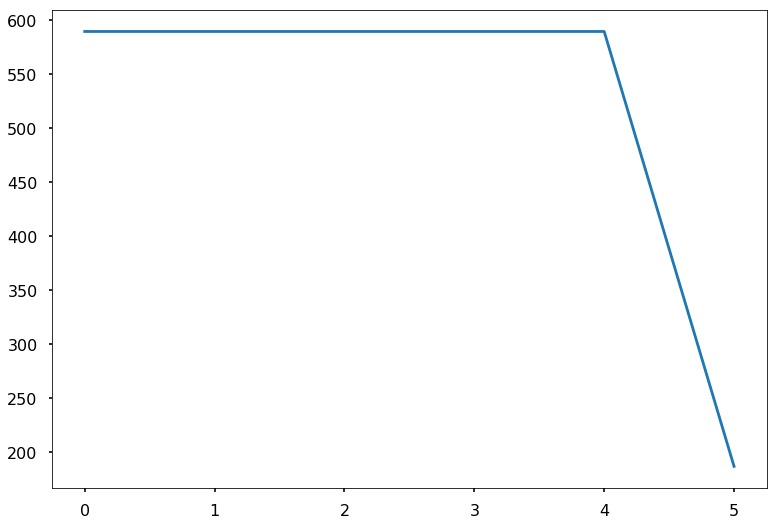

In [6]:
seuil_a = optimisation_seuil(seuil = 'a', pas = 0.1, debut = -0.5, fin= 0)

Gradient Descent
====
For now, the basic implementation is theorically correct, but it is not effective. Don't pay attention then.


1


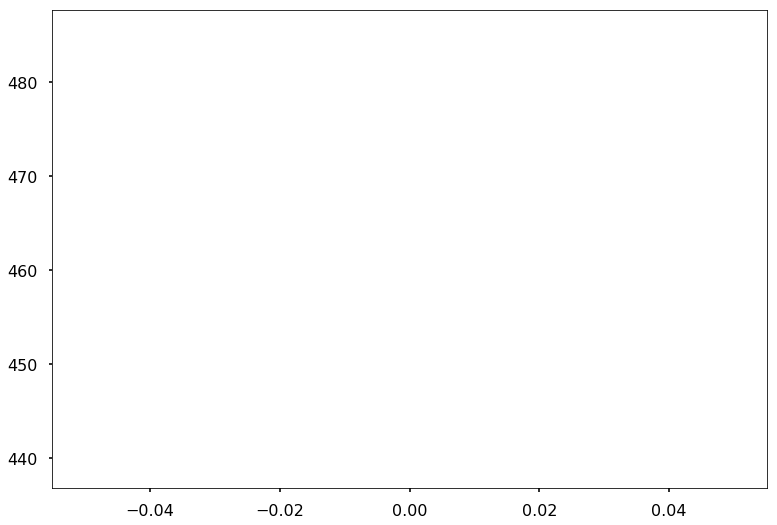

In [7]:
# Gradient Descent
def gainfunction(seuil_a, seuil_b, seuil_c, seuil_d):
    df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, seuil_b, seuil_c, seuil_d), axis=1)
    decisions_list = df_primary['macd_decision'].values.tolist()
    market_prices = df_primary['variation'].values.tolist()
    gain = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3, gradient = True)
    return(gain)

liste_gain = []

alpha = 0.0000000001 # learning rate
nb_max_iter = 1 # Nb max d'iteration

seuil_a_0 = -0.05 # start point00
seuil_b_0 =  0.002
seuil_c_0 = 0.014 
seuil_d_0 = -0.0225


pas = 0.0001

nb_iter = 0 

while nb_iter < nb_max_iter:

    
    seuil_a_1 = seuil_a_0 - alpha * ((gainfunction(seuil_a_0 + pas, seuil_b_0, seuil_c_0, seuil_d_0) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_b_1 = seuil_b_0 - alpha * ((gainfunction(seuil_a_0, seuil_b_0 + pas, seuil_c_0, seuil_d_0) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_c_1 = seuil_c_0 - alpha * ((gainfunction(seuil_a_0, seuil_b_0, seuil_c_0 + pas, seuil_d_0) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_d_1 = seuil_d_0 - alpha * ((gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0 + pas) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_a_0 = seuil_a_1
    seuil_b_0 = seuil_b_1
    seuil_c_0 = seuil_c_1
    seuil_d_0 = seuil_d_1

    gain = gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)

    liste_gain.append(gain)
    nb_iter = nb_iter + 1
    print(nb_iter)

L = [i for i in range(len(liste_gain))]

plt.plot(L, liste_gain)
plt.show()

Display of MACD strategy results once optimized
====

In [8]:
def display_macd_strategy(df, debut = None, fin = None, efficiency = False):
#création du vecteur de décision
    df_primary['macd_decision'] =  df_primary.apply(macd, args = (-0.5, 0.0019, 0.014, -0.0225,), axis=1)
    seuil_a_0 = -0.05 
    seuil_b_0 =  0.002
    seuil_c_0 = 0.014 
    seuil_d_0 = -0.0225

    #df visualisé, on choisit dans le iloc de quand a quand on veut observer nos résultats
    dh = df_primary.copy()
    dh = dh.iloc[debut:fin,:]

    #on prélève les listes utiles a nos fonctions du dataframe
    decisions_list = dh['macd_decision'].values.tolist()
    market_prices = dh['variation'].values.tolist()
    
    #classic
    if not efficiency:
        decisions_results = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        L = [i for i in range(len(decisions_results))]
        
        #affichage de nos résultats
        plt.plot(L, decisions_results)
        plt.plot(L, market_var)
        plt.show()

    #efficiency
    else:
        decisions_results, decisions_results_evite = strategy_based_results(decisions_list, market_prices, fee_rate = 0, efficiency = True)
        market_var = buy_hold_results(market_prices)
        L = [i for i in range(len(decisions_results))]
        J = [j for j in range(len(decisions_results_evite))]

        #affichage de nos résultats
        plt.plot(L, decisions_results)
        plt.show()
        plt.plot(J, decisions_results_evite)
        plt.show()
        

Gain total =  489.52 %.
Nombre de transactions =  38
Argent dépensé en commissions =  50.72 %.
Nombre de chandeliers sans cash engagé =  1908
Nombre de chandeliers sur lesquels on a juste hold =  3219


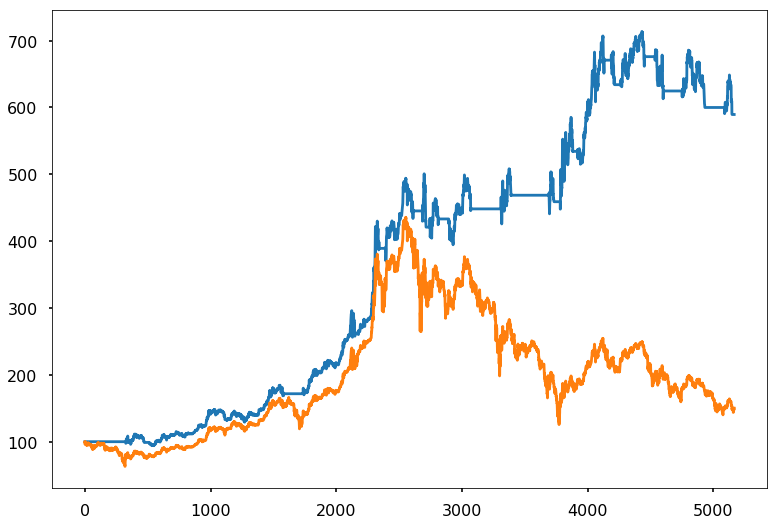

In [9]:
#efficiency
#display_macd_strategy(df_primary, debut = None, fin = None, efficiency = True)
#classic
display_macd_strategy(df_primary, debut = None, fin = None, efficiency = False)

Bollinger strategy out of the boundaries
====
bdb_high
----
The same computing that macd

Note
---
Bien se faire un schéma dans la tête pour ne pas faire de faute
On doit avoir notre bdb_high qui doit être inférieur à 1 donc seuil doit être inférieur à 1
pour bdb_low c'est l'inverse

In [10]:
 def bdb_high(data_row, seuil_bdb_high):
        
    bdb_high = data_row['bdb_high_n']
    if bdb_high < seuil_bdb_high:
        return -1
    else:
        return 0


bdb_low
----

In [11]:
 def bdb_low(data_row, seuil_bdb_low):
        
    bdb_low = data_row['bdb_low_n']
    if bdb_low > seuil_bdb_low:
        return 1
    else:
        return 0


Visualisation just Bollinger
----

In [12]:
 def macd(data_row, seuil_a = -0.05, seuil_b = 0.0019, seuil_c = 0.014, seuil_d = -0.0225):
        
    macd = data_row['macd_n']
    macd_derivative = data_row['macd_derivative_n']
    macd_historic = data_row['macd_historic']
    
    if macd >= seuil_a:
        if macd_derivative > seuil_b and macd_historic > seuil_c:
            return 1
        else:
            if macd_historic <= seuil_d:
                return -1
            else:
                return 0
    else:
        return -1
    
def bdb_high(data_row, seuil_bdb_high):
        
    bdb_high = data_row['bdb_high_n']
    if bdb_high < seuil_bdb_high:
        return -1
    else:
        return 0    
    
def bdb_low(data_row, seuil_bdb_low):
        
    bdb_low = data_row['bdb_low_n']
    if bdb_low > seuil_bdb_low:
        return 1
    else:
        return 0

Decision_vector
----
To complete this we are doing this study with MACD as a complement.
Bollinger is the rule that prevails.

In [13]:
def decision_vector(data_row):
    macd_decision = data_row['macd_decision']
    bdb_low_decision = data_row['bdb_low_decision']
    bdb_high_decision = data_row['bdb_high_decision']
    #print(bdb_high_decision,bdb_low_decision)
    if bdb_low_decision == 0 and bdb_high_decision == 0:
        return macd_decision
    elif bdb_low_decision == 1: 
        return 1
    elif bdb_high_decision == -1:
        return -1

Optimisation
====
Direct optimisation with MACD rule

In [14]:
def optimisation_bdb_out(df, seuil, pas, debut = 1, fin = 1.1, seuil_low = 1, seuil_high = 1, ti = None, tf = None):
    dg = df.copy()
    dg = dg.iloc[ti:tf]
    liste_gain = []
    init = debut
    if seuil == 'low':
        while debut <= fin:
            #vecteur de decision
            dg['bdb_low_decision'] = dg.apply(bdb_low, args = (debut,), axis = 1)
            dg['bdb_high_decision'] = dg.apply(bdb_high, args = (seuil_high,), axis = 1)
            dg['macd_decision'] = dg.apply(macd, axis = 1)
            dg['decision_vector'] = dg.apply(decision_vector, axis = 1)
            #listes pour fonctions
            decisions_list = dg['decision_vector'].values.tolist()
            market_prices = dg['variation'].values.tolist()
            #fonction d'analyse
            decisions_results = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3, gradient = True)
            liste_gain.append(decisions_results)
            #iteration
            reste = (fin - debut) / pas
            print(str(round(reste,0)))
            debut += pas
        #index
        index = liste_gain.index(max(liste_gain))
        seuil_low_out =   index * pas + init
        print("Index du max = ", str(round(seuil_low_out ,4)))
        print("Gain au max =", str(round(max(liste_gain),2)))
        #plot results
        L = [i for i in range(len(liste_gain))]
        plt.plot(L, liste_gain)
        plt.show()
        return seuil_low_out


    if seuil == 'high':
        while debut >= fin:
            #vecteur de decision
            dg['bdb_low_decision'] = dg.apply(bdb_low, args = (seuil_low,), axis = 1)
            dg['bdb_high_decision'] = dg.apply(bdb_high, args = (debut,), axis = 1)
            dg['macd_decision'] = dg.apply(macd, axis = 1)
            dg['decision_vector'] = dg.apply(decision_vector, axis = 1)
            #listes pour fonctions
            decisions_list = dg['decision_vector'].values.tolist()
            market_prices = dg['variation'].values.tolist()
            #fonction d'analyse
            decisions_results = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3, gradient = True)
            liste_gain.append(decisions_results)
            #iteration
            reste = (debut - fin) / pas
            print(str(round(reste,0)))
            debut -= pas
        #print(dg.head())
        #index
        index = liste_gain.index(max(liste_gain))
        seuil_high_out = - index * pas + init
        print("Index du max = ", str(round(seuil_high_out ,4)))
        print("Gain au max =", str(round(max(liste_gain),2)))
        #plot results
        L = [i for i in range(len(liste_gain))]
        plt.plot(L, liste_gain)
        plt.show()
        return seuil_high_out

100.0
99.0
98.0
97.0
96.0
95.0
94.0
93.0
92.0
91.0
90.0
89.0
88.0
87.0
86.0
85.0
84.0
83.0
82.0
81.0
80.0
79.0
78.0
77.0
76.0
75.0
74.0
73.0
72.0
71.0
70.0
69.0
68.0
67.0
66.0
65.0
64.0
63.0
62.0
61.0
60.0
59.0
58.0
57.0
56.0
55.0
54.0
53.0
52.0
51.0
50.0
49.0
48.0
47.0
46.0
45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
0.0
Index du max =  1.027
Gain au max = 1192.42


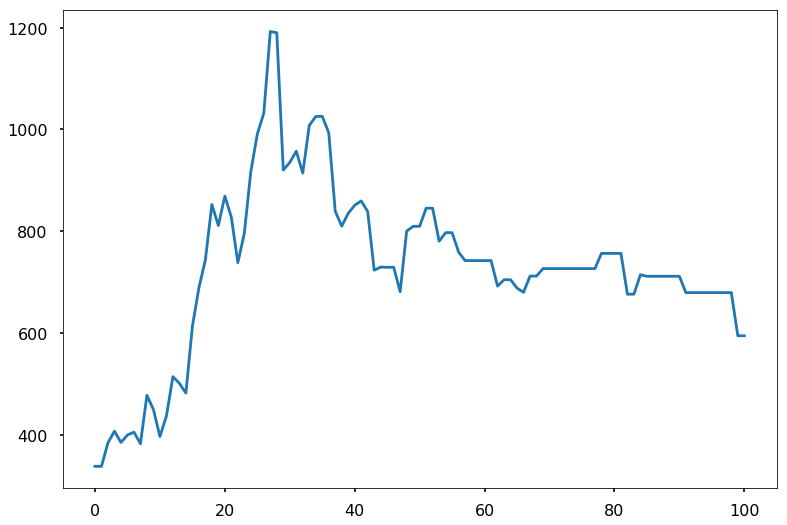

1.027

In [15]:
optimisation_bdb_out(df_primary, seuil = 'low', pas = 0.01, debut = 1, fin = 1.1, 
                     seuil_low = 1.049, seuil_high = 0.941, ti = None, tf = None)
#seuil high < 1
#seuil low > 1

Display MACD / Bollinger_out strategy combined once optimized
====

In [16]:
import results
def display_bollinger_out_strategy(df, debut = None, fin = None, seuil_bdb_high = 0.941, seuil_bdb_low = 1.049, efficiency = False, bollinger_alone = False):
    
    #définition domaine d'étude
    dg = df.copy()
    dg = dg.iloc[debut:fin]
    #création des vecteurs de décision
    
    dg['bdb_high_decision'] =  dg.apply(bdb_high, args = (seuil_bdb_high,), axis = 1)#0.941
    dg['bdb_low_decision'] =  dg.apply(bdb_low, args = (seuil_bdb_low,), axis = 1)#1.049
    if not bollinger_alone:
        dg['macd_decision'] = dg.apply(macd, args = (-0.5, 0.0019, 0.014, -0.0225), axis = 1)
        #print(dg["macd_decision"].values.tolist())
    elif bollinger_alone:
        #retourne une colonne avec que des 0
        dg['macd_decision'] = dg.apply(macd, args = (-1,1,-1,-1), axis = 1)
    dg['decision_vector'] = dg.apply(decision_vector, axis = 1)
    #print(dg['decision_vector'].values.tolist())
    #Listes nécessaires aux fonctions
    decisions_list = dg['decision_vector'].values.tolist()
    market_prices = dg['variation'].values.tolist()

        #classic
    if not efficiency:
        #fonctions appliquées
        decisions_results = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        L = [i for i in range(len(decisions_results))]
        
        #affichage de nos résultats
        plt.plot(L, decisions_results)
        plt.plot(L, market_var)
        plt.show()
        results.plot_strategy(decisions_list, market_var, notebook=False)
        

    #efficiency
    else:
        #fonctions appliquées
        decisions_results, decisions_results_evite = strategy_based_results(decisions_list, market_prices, fee_rate = 0, efficiency = True)
        market_var = buy_hold_results(market_prices)
        L = [i for i in range(len(decisions_results))]
        J = [j for j in range(len(decisions_results_evite))]

        #affichage de nos résultats
        plt.plot(L, decisions_results)
        plt.show()
        plt.plot(J, decisions_results_evite)
        plt.show()
    return(decisions_list)



Gain total =  1111.72 %.
Nombre de transactions =  180
Argent dépensé en commissions =  412.1 %.
Nombre de chandeliers sans cash engagé =  1711
Nombre de chandeliers sur lesquels on a juste hold =  3274


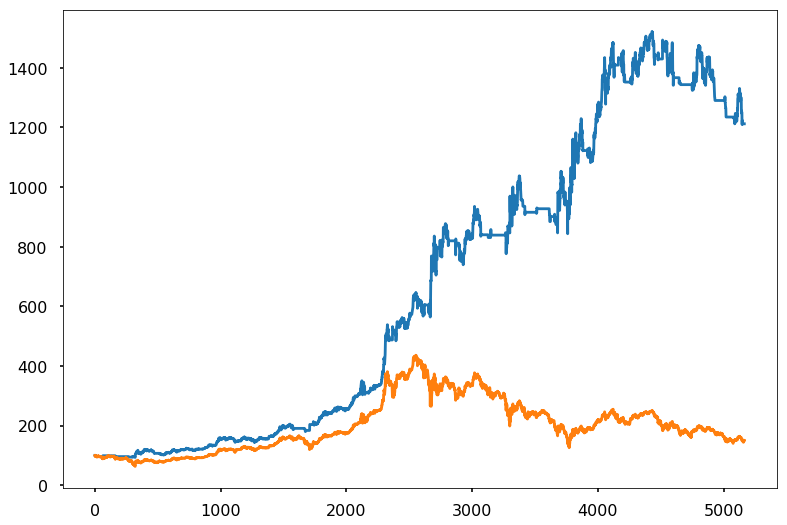

In [17]:
decisions_list = display_bollinger_out_strategy(df, debut = None, fin = None, seuil_bdb_high = 0.941, 
                               seuil_bdb_low = 1.02788, efficiency = False, bollinger_alone = False)


Analysis Bloc 
====
Objective : Use the gap variation between the Bande de bollinger, to find other ways to make decisions <br>
L'idée de cette stratégie est de calculer la variation de l'écart entre les bandes de Bollinger. On construit la liste bdb_gap dans laquelle on a classé de manière décroissante cette variation d'écart entre les bandes.

Ensuite pour savoir si c'est une hausse ou une baisse qui doit avoir lieu on se base sur la valeur de bdb_low (si cette valeur est inférieure à 1 on peut raisonnablement se dire que ce sera une hausse. Sinon que c'est une baisse.

On a alors notre critère pour créer un vecteur de décision basé sur la variation de cet écartement.

0.018757573631766777 50.789956714307536 10


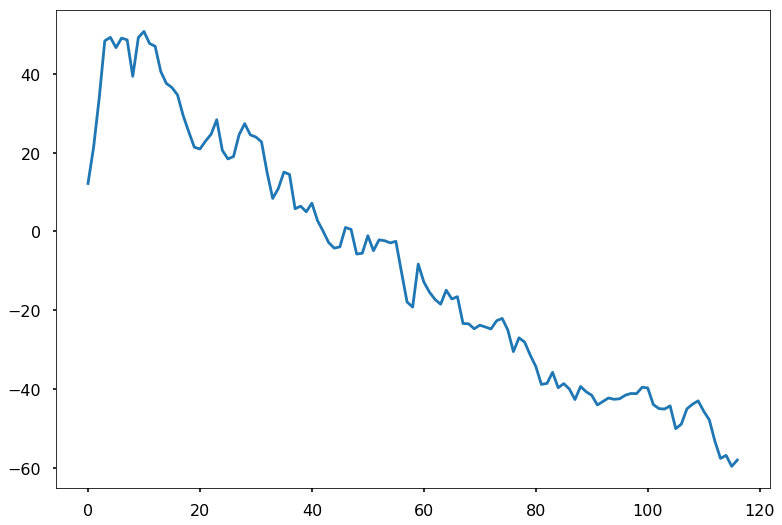

In [18]:

#print(df_primary[['bdb_gap', 'variation']].sort_values(by='bdb_gap', ascending=True))
df_primary['bdb_gap_derivate'] = df_primary['bdb_gap'] - df_primary['bdb_gap'].shift(1)
bdb_gap = df_primary[['bdb_gap_derivate', 'variation','bdb_low_n']].sort_values(by='bdb_gap_derivate', ascending=False).values.tolist()
#print(bdb_gap)
total_sum = []
variation_sum = 0
#print(bdb_gap)
for j in range(200):
    if bdb_gap[j][2] > 1:
        variation_sum += bdb_gap[j+1][1] - 0.3
        total_sum.append(variation_sum)
    else:
        variation_sum -= bdb_gap[j+1][1] + 0.3

max_index = total_sum.index(max(total_sum))
bdb_gap_threshold = bdb_gap[max_index][0]
print(bdb_gap_threshold, max(total_sum), max_index)
L = [i for i in range(len(total_sum))]
plt.plot(L, total_sum)
plt.show()
#df_primary[['bdb_gap_derivate', 'variation']].sort_values(by='bdb_gap_derivate', ascending=True)

#list_gap = bdb_gap[0:123]


In [19]:
#0.014762748390195313
def bdb_gap(data_row, seuil_bdb_gap = 0.014762748390195313):
        
    bdb_gap = data_row['bdb_gap_derivate']
    bdb_low = data_row['bdb_low_n']
    
    if bdb_gap < seuil_bdb_gap:
        return 0
    else:
        if bdb_low > 1:
            return 1
        else:
            return -1

In [20]:
#penser a combiner un indicateur de volume avec bollinger pour confirmer une fortre volatilité